## Stage 3: CNN Classifier
The manual approach, yielded some positive results
Let's see if a machine learning algorithm using similar information might also work

**Plan:**

Chord Qualities:
1. Compute the summed frequency array, and note bin arrays
2. Put these into a CNN (try different combinations)
3. Try a few other models, including:
    - random forest
    - hmm
    - knn

Root Notes:
1. Given the calculated quality and frequency volume, try to work out what the root note is

In [194]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.io.wavfile import read as read_wav
from scipy import fft,signal
from sklearn.preprocessing import minmax_scale
import warnings
from tqdm import tqdm
import tensorflow_io as tfio

TONE_A = 440 
NOTES = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#'] 

In [93]:
def freq_to_rnote(freq):
    r = 12.0*np.log2(freq/TONE_A)
    return r

def rnote_to_freq(r):
    f = TONE_A*2**(r/12)
    return f

def get_note_volume(rnote,fft_image,fft_freq,rnote_epsilon=0.2):
    """ rnote - name or number of note,fft_image - fourier image of signal,
    fft_freq - frequencies in fft_image,rnote_epsilon - halfwide of window to inspect
    return maximum volume(magnitude) of signal in freq window for rnote """
    if isinstance(rnote,str):
        rnote = NOTES.index(rnote)
    try:
        f0 = rnote_to_freq(rnote-rnote_epsilon)
        f1 = rnote_to_freq(rnote+rnote_epsilon)
        f_idx = np.where((fft_freq>=f0)&(fft_freq<=f1)) 
        maxVol = np.max((fft_image[f_idx]))
    except Exception:
        return 0.
    
    return maxVol

def get_notes_volume(rnote,fft_image,fft_freq,rnote_epsilon=0.5,oct_range_from=-4.,oct_range_to=8.):
    if isinstance(rnote,str):
        rnote = NOTES.index(rnote)
    rnotes = np.arange(rnote+12.*oct_range_from,rnote+12.*oct_range_to,12.0)
    vol = []
    for rn in rnotes:
        vol.append(get_note_volume(rn,fft_image,fft_freq))
        
    return np.max(vol)

def plot_notes(fileName):
    """convert the fft image from file to notes notations and plot on"""
    #print(fileName)
    rate,data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) # stereo of any type -> mono of float32
    data = minmax_scale(data,(-1.,1.)) 
    fft_image = np.abs(fft.rfft(data,norm='forward')) 
    fft_freq = fft.rfftfreq(len(data),1./rate)
    vol_matrix = np.ndarray(shape=(12),dtype=np.float32)
    for rnote in range(12):
        vol_matrix[rnote] = get_notes_volume(rnote,fft_image,fft_freq)
        
    plt.bar(NOTES, vol_matrix)
    plt.show()

In [179]:
# try it out on a few of the files in /data/train_set.csv:
train_set = pd.read_csv('data/train_set.csv')
test_set = pd.read_csv('data/test_set.csv')
print(train_set.head())

# remove the chords that are not maj or min in the Quality column
train_set = train_set[train_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]
test_set = test_set[test_set['Quality'].isin(['maj', 'min', 'dim', 'aug'])]

                                    File Path Root Note  Octave Quality  \
0        data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7     dim   
1   data/chords/min7b5/C-3-min7b5-chord-1.wav         C       3  min7b5   
2       data/chords/dim7/E-6-dim7-chord-0.wav         E       6    dim7   
3        data/chords/min/Bb-5-min-chord-0.wav        Bb       5     min   
4  data/chords/maj7_2/Ab-5-maj7_2-chord-0.wav        Ab       5  maj7_2   

   Inversion  
0          1  
1          1  
2          0  
3          0  
4          0  


In [134]:
print(train_set.groupby(['Quality']).count())
print(test_set.groupby(['Quality']).count())

         File Path  Root Note  Octave  Inversion
Quality                                         
aug            179        179     179        179
dim            178        178     178        178
maj            178        178     178        178
min            178        178     178        178
         File Path  Root Note  Octave  Inversion
Quality                                         
aug             76         76      76         76
dim             77         77      77         77
maj             77         77      77         77
min             77         77      77         77


In [135]:
len(train_set)
# summarise the data
train_set['Quality'].describe()


count     713
unique      4
top       aug
freq      179
Name: Quality, dtype: object

In [180]:
# preprocessing:
def preprocess(fileName):
    rate, data_raw = read_wav(fileName)
    data = (data_raw[:,0]+data_raw[:,1]).astype(np.float32) # stereo of any type -> mono of float32
    data = minmax_scale(data,(-1.,1.))
    fft_image = np.abs(fft.rfft(data,norm='forward'))
    fft_freq = fft.rfftfreq(len(data),1./rate)
    note_volumes = []
    for note in NOTES:        
    
        note_volumes.append(get_note_volume(note,fft_image,fft_freq))
    # print(note_volumes)
    
    return note_volumes

# create a new dataframe with the note volumes
train_note_volumes = pd.DataFrame(columns=NOTES)
test_note_volumes = pd.DataFrame(columns=NOTES)    

for i in tqdm(range(len(train_set))):
    fileName = train_set['File Path'].iloc[i]
    note_volumes = preprocess(fileName)
    # print the shape of note_volumes
    # print(note_volumes.shape)
    for j in range(len(note_volumes)):
        train_note_volumes.at[i, NOTES[j]] = note_volumes[j]

for i in tqdm(range(len(test_set))):
    fileName = test_set['File Path'].iloc[i]
    note_volumes = preprocess(fileName)
    for j in range(len(note_volumes)):
        test_note_volumes.at[i, NOTES[j]] = note_volumes[j]
        # test_set.iloc[i][NOTES[j]] = note_volumes[j]
        # test_set.at[i, NOTES[j]] = note_volumes[j]


100%|██████████| 307/307 [00:00<00:00, 314.66it/s]


In [181]:

# summarise the quality column in train_set
train_set['Quality'].describe()

# show each quality in train_set and how many there are
train_set.groupby(['Quality']).count()


# how many nan values are there in the train_set?

# add the qualities to the note_volumes dataframe
train_note_volumes['Quality'] = train_set['Quality']
test_note_volumes['Quality'] = test_set['Quality']

len(train_note_volumes)


# print(train_set)


713

In [154]:
train_note_volumes['Quality'].isnull().sum()
train_note_volumes['Quality'].describe()
train_note_volumes.head()

,A,A#,B,C,C#,D,D#,E,F,F#,G,G#,Quality
0,0.00003,0.000025,0.000018,0.000055,0.000036,0.000027,0.000013,0.000015,0.000025,0.000013,0.000023,0.000039,dim
1,0.000044,0.000055,0.000015,0.000029,0.000035,0.000057,0.000049,0.000026,0.000057,0.000043,0.000023,0.000062,min
2,0.000499,0.000167,0.000135,0.007999,0.000137,0.00011,0.005141,0.000042,0.00003,0.000057,0.0023,0.002004,maj
3,0.000124,0.000125,0.002133,0.00356,0.000071,0.000068,0.002209,0.002292,0.000042,0.000077,0.002329,0.002155,aug
4,0.000223,0.000155,0.008392,0.000298,0.000249,0.000301,0.0052,0.000319,0.000039,0.000159,0.005519,0.000599,aug


In [70]:

from sklearn.preprocessing import MinMaxScaler
# Assuming df is your DataFrame and it's already been normalized row-wise

# Create a scaler object
scaler = MinMaxScaler()

# Fit and transform the data but not for the 'File Path', Inversion, Root Note, Quality, and Chord Name columns

columns_to_scale = train_set.drop(columns=['File Path', 'Quality', 'Root Note', 'Octave', 'Inversion']).columns
train_set[columns_to_scale] = scaler.fit_transform(train_set[columns_to_scale])

print(train_set.head())

                               File Path Root Note  Octave Quality  Inversion  \
0   data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7     dim          1   
3   data/chords/min/Bb-5-min-chord-0.wav        Bb       5     min          0   
20  data/chords/maj/Ab-3-maj-chord-1.wav        Ab       3     maj          1   
28  data/chords/aug/Ab-2-aug-chord-0.wav        Ab       2     aug          0   
32   data/chords/aug/G-4-aug-chord-1.wav         G       4     aug          1   

           A        A#         B         C        C#         D        D#  \
0   0.000693  0.030367  0.000416  0.000121  0.009097  0.000226  0.000272   
3   0.000693  0.030367  0.000416  0.000121  0.009097  0.000226  0.000272   
20  0.000693  0.030367  0.000416  0.000121  0.009097  0.000226  0.000272   
28  0.000693  0.030367  0.000416  0.000121  0.009097  0.000226  0.000272   
32  0.000693  0.030367  0.000416  0.000121  0.009097  0.000226  0.000272   

           E         F        F#         G        G#  
0

In [155]:
print(train_note_volumes['Quality'].unique())
print(len(train_set))
# remove the chords that have nan values in train_set
train_set = train_set.dropna()

['dim' 'min' 'maj' 'aug']
713


In [182]:
# run a CNN on the data, using the note volumes as the input and the chord quality as the output
# Path: stage_3_cnn_classifier_part_2.ipynb

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

num_classes = 4
height = 12
width = 1
channels = 1

model = Sequential()

# Add Convolutional layers
model.add(Conv1D(32, 3, activation='relu', input_shape=(height, channels)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten the output to feed into dense layers
model.add(Flatten())

# Add Dense layers
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/Users/adrianmcintosh/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [184]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Assuming you have already loaded train_note_volumes and labels from your data
# Make sure to convert labels to categorical

# Convert labels to categorical one-hot encoding
labels_categorical = to_categorical(train_note_volumes['Quality'], num_classes=4)

# make input_data a combination of train_note_volumes and test_note_volumes

input_data = np.concatenate((train_note_volumes.drop(columns=['Quality']), test_note_volumes.drop(columns=['Quality'])), axis=0)

# Reshape input data to have a channel dimension
input_data = input_data.reshape(input_data.shape[0], input_data.shape[1], 1)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(input_data, labels_categorical, test_size=0.2, random_state=42)

# Build a simple CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(input_data.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))  # For multi-class classification with 4 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(input_data, labels_categorical)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


ValueError: invalid literal for int() with base 10: 'dim'

In [183]:

# train_reshaped = train_set_note_volumes.reshape(train_set_note_volumes.shape[0], height, channels)
# test_reshaped = test_set_note_volumes.reshape(train_set_note_volumes.shape[0], height, channels)
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Convert string inputs to numerical labels
label_encoder = LabelEncoder()
train_set_encoded = label_encoder.fit_transform(train_set["Quality"])
test_set_encoded = label_encoder.transform(test_set["Quality"])

# show the classes in train_set["Quality"]
print(label_encoder.classes_)

# summarize the classes of train_set_encoded and test_set_encoded
# count the number of classes in train_set_encoded and test_set_encoded
print(train_set_encoded)
print(test_set_encoded)

print(len(np.unique(train_set_encoded)))
print(len(np.unique(test_set_encoded)))

# One-hot encode the numerical labels
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
train_set_one_hot = onehot_encoder.fit_transform(train_set_encoded.reshape(-1, 1))
test_set_one_hot = onehot_encoder.transform(test_set_encoded.reshape(-1, 1))

# Check the number of classes in train_set_one_hot and test_set_one_hot
print(train_set_one_hot[0])
print(test_set_one_hot[0])

# fit the model using train_set_note_volumes and train_set_one_hot, but exclude the File Path, Quality, and Root Note columns
model.fit(train_note_volumes.drop(columns=['Quality']), train_set_one_hot, epochs=3, batch_size=100)

# evaluate on test_set
model.evaluate(test_note_volumes, test_set_one_hot)


['aug' 'dim' 'maj' 'min']
[1 3 2 0 0 3 2 1 3 1 3 2 3 0 0 0 3 3 1 1 2 1 2 1 2 2 2 0 1 2 2 0 0 0 1 0 0
 1 1 0 2 0 0 1 2 3 0 3 1 0 0 1 1 1 2 1 2 0 3 3 3 0 2 1 1 1 2 0 2 2 1 2 0 0
 3 1 2 2 0 2 0 1 3 3 3 3 3 2 1 1 2 3 3 0 3 3 3 1 3 3 2 2 0 0 1 2 0 2 1 1 1
 2 2 2 3 3 3 3 2 3 0 1 1 0 3 2 1 3 0 2 3 0 2 2 0 0 0 0 3 1 2 2 1 1 2 2 1 2
 2 3 0 3 0 0 1 0 1 2 3 1 3 2 3 1 2 3 2 2 2 0 2 3 3 3 1 1 3 3 3 1 0 0 1 0 3
 1 3 0 0 3 1 1 0 0 1 1 0 0 0 2 0 0 2 3 1 3 3 3 3 0 2 1 3 3 3 1 2 0 3 0 3 1
 0 0 0 1 0 0 1 1 0 3 1 1 1 0 0 0 3 1 3 1 3 2 2 2 2 3 3 2 0 1 2 3 0 1 1 2 3
 0 0 1 2 2 1 3 3 0 3 2 3 2 1 1 0 1 1 2 0 3 0 3 2 0 0 0 0 1 0 2 2 2 1 2 3 1
 2 3 0 1 3 0 1 3 2 1 0 0 3 3 2 3 2 0 2 1 3 3 2 1 1 2 0 2 1 1 0 0 3 2 3 0 0
 3 0 1 0 3 2 2 2 1 0 0 0 3 2 0 3 0 3 0 3 3 0 0 3 1 2 3 2 0 2 1 2 0 1 0 0 3
 0 2 2 1 0 1 0 1 0 1 2 1 1 2 0 1 0 3 2 2 2 1 0 2 3 2 1 0 0 0 0 1 3 2 0 2 3
 3 3 2 1 2 2 3 1 1 1 0 2 3 1 0 2 1 3 2 3 1 3 2 1 1 3 3 1 2 2 3 0 0 3 3 3 2
 3 0 3 0 3 0 0 3 1 2 3 3 3 0 1 0 3 3 1 1 2 1 2 0 3 0 1 3 3 3 2 1 3 0 1 0 0

/Users/adrianmcintosh/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.float32).

In [165]:
# normalise the data so that the volum
train_set_one_hot
len(train_set_one_hot)
train_note_volumes.head()

,A,A#,B,C,C#,D,D#,E,F,F#,G,G#,Quality
0,0.00003,0.000025,0.000018,0.000055,0.000036,0.000027,0.000013,0.000015,0.000025,0.000013,0.000023,0.000039,dim
1,0.000044,0.000055,0.000015,0.000029,0.000035,0.000057,0.000049,0.000026,0.000057,0.000043,0.000023,0.000062,min
2,0.000499,0.000167,0.000135,0.007999,0.000137,0.00011,0.005141,0.000042,0.00003,0.000057,0.0023,0.002004,maj
3,0.000124,0.000125,0.002133,0.00356,0.000071,0.000068,0.002209,0.002292,0.000042,0.000077,0.002329,0.002155,aug
4,0.000223,0.000155,0.008392,0.000298,0.000249,0.000301,0.0052,0.000319,0.000039,0.000159,0.005519,0.000599,aug


In [167]:
# try running random forrests on the data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rf.fit(train_note_volumes.drop(columns=['Quality']), train_set_one_hot)
preds = rf.predict(test_note_volumes.drop(columns=['Quality']))
print(preds)
accuracy_score(test_set_one_hot, preds)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


0.18566775244299674

In [29]:
# try running a neural network on the data
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=12))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

sgd = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_set.drop(columns=['File Path', 'Quality', 'Root Note', 'Octave', 'Inversion']), train_set_one_hot, epochs=3, batch_size=100)

Epoch 1/3


/Users/adrianmcintosh/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:73: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/adrianmcintosh/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/base_optimizer.py:31: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.2162 - loss: 1.3865
Epoch 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.2269 - loss: 1.3861
Epoch 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2608 - loss: 1.3866 


In [178]:
# try running knn on the data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_note_volumes.drop(columns=['Quality']), train_note_volumes['Quality'])
preds = knn.predict(test_note_volumes.drop(columns=['Quality']))
accuracy_score(test_set['Quality'], preds)


0.0

In [177]:
# for every chord quality, set it to 0, 1, 2, 3
train_set['Quality'] = train_set['Quality'].replace(['maj', 'min', 'dim', 'aug'], [0, 1, 2, 3])
test_set['Quality'] = test_set['Quality'].replace(['maj', 'min', 'dim', 'aug'], [0, 1, 2, 3])

# try running xgboost on the data
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(train_note_volumes.drop(columns=['Quality']), train_set['Quality'])
preds = xgb.predict(test_note_volumes.drop(columns=['Quality']))
accuracy_score(test_set['Quality'], preds)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:A: object, A#: object, B: object, C: object, C#: object, D: object, D#: object, E: object, F: object, F#: object, G: object, G#: object

In [35]:
# try running a naive bayes classifier on the data
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gnb = GaussianNB()
gnb.fit(train_set_note_volumes.drop(columns=['File Path', 'Quality', 'Root Note']), train_set['Quality'])
preds = gnb.predict(test_set_note_volumes.drop(columns=['File Path', 'Quality', 'Root Note']))
accuracy_score(test_set['Quality'], preds)

0.19543973941368079

In [ ]:
accuracy = model.evaluate(test_reshaped, test_set_one_hot)[1]
print(f"Test Accuracy: {accuracy * 100:.2f}%")


In [36]:
# try running xgboost on the data
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier()
xgb.fit(train_set_note_volumes.drop(columns=['File Path', 'Quality', 'Root Note']), train_set['Quality'])
preds = xgb.predict(test_set_note_volumes.drop(columns=['File Path', 'Quality', 'Root Note']))
accuracy_score(test_set['Quality'], preds)


0.50814332247557

In [37]:
# try linear regression on the data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score



lr = LinearRegression()
lr.fit(train_set_note_volumes.drop(columns=['File Path', 'Quality', 'Root Note']), train_set['Quality'])
preds = lr.predict(test_set_note_volumes.drop(columns=['File Path', 'Quality', 'Root Note']))
accuracy_score(test_set['Quality'], preds)


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [46]:
# print a summary of train_set
print(train_set.head())
print(train_set_note_volumes.head())

# summarise note volumes
print(train_set_note_volumes.describe())

                               File Path Root Note  Octave  Quality  Inversion
0   data/chords/dim/Eb-7-dim-chord-1.wav        Eb       7        2          1
3   data/chords/min/Bb-5-min-chord-0.wav        Bb       5        1          0
20  data/chords/maj/Ab-3-maj-chord-1.wav        Ab       3        0          1
28  data/chords/aug/Ab-2-aug-chord-0.wav        Ab       2        3          0
32   data/chords/aug/G-4-aug-chord-1.wav         G       4        3          1
          0         1         2         3         4         5         6  \
0  0.000030  0.000025  0.000018  0.000055  0.000036  0.000027  0.000013   
1  0.000044  0.000055  0.000015  0.000029  0.000035  0.000057  0.000049   
2  0.000499  0.000167  0.000135  0.007999  0.000137  0.000110  0.005141   
3  0.000124  0.000125  0.002133  0.003560  0.000071  0.000068  0.002209   
4  0.000223  0.000155  0.008392  0.000298  0.000249  0.000301  0.005200   

          7         8         9        10        11  \
0  0.000015  0.00002

In [233]:
import numpy as np
import scipy.io.wavfile as wav
import scipy.signal as signal

def load_wav_16k_mono(filename):
    sample_rate, wav_data = wav.read(filename)
    if wav_data.ndim > 1:
        wav_data = wav_data[:, 0]
    return wav_data, sample_rate

# def preprocess(file_path, label):
#     wav_data, sample_rate = load_wav_16k_mono(file_path)
#     wav_data = wav_data[:48000]
#     zero_padding = np.zeros(48000 - len(wav_data), dtype=np.float32)
#     wav_data = np.concatenate([zero_padding, wav_data])
#     spectrogram = np.abs(signal.stft(wav_data, nperseg=320, noverlap=288)[2])
#     spectrogram = np.expand_dims(spectrogram, axis=2)
#     return spectrogram, label

def preprocess(file_path, label):
    wav_data, sample_rate = load_wav_16k_mono(file_path)
    wav_data = wav_data[:48000]
    zero_padding = np.zeros(48000 - len(wav_data), dtype=np.float32)
    wav_data = np.concatenate([zero_padding, wav_data])
    spectrogram = np.abs(signal.stft(wav_data, nperseg=320, noverlap=288)[2])
    
    # Add an extra dimension to the spectrogram before resizing
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    
    # Ensure the spectrogram has the correct dimensions
    spectrogram = tf.image.resize(spectrogram, [1501, 161])

    return spectrogram, label

# def preprocess(file_path, label):
#     wav = load_wav_16k_mono(file_path)
#     wav = wav[:48000]
#     zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
#     wav = tf.concat([zero_padding, wav],0)
#     spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
#     spectrogram = tf.abs(spectrogram)
#     spectrogram = tf.expand_dims(spectrogram, axis=2)
#     return spectrogram, label

In [234]:
spectrogram, label = preprocess(train_set['File Path'].iloc[0], train_set['Quality'].iloc[0])


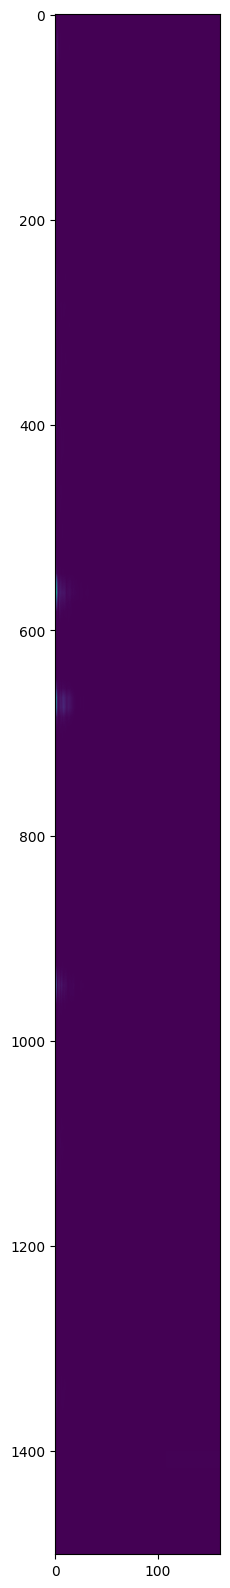

In [235]:
plt.figure(figsize=(30,20))
plt.imshow(spectrogram)
plt.show()

In [210]:
# get the dimensions of spectrogram
spectrogram.shape

(161, 1501, 1)

In [215]:
train_set_reduced.head()

,File Path,Quality
0,data/chords/dim/Eb-7-dim-chord-1.wav,dim
3,data/chords/min/Bb-5-min-chord-0.wav,min
20,data/chords/maj/Ab-3-maj-chord-1.wav,maj
28,data/chords/aug/Ab-2-aug-chord-0.wav,aug
32,data/chords/aug/G-4-aug-chord-1.wav,aug


In [218]:

# Create a tf.data.Dataset from your DataFrame
file_paths = tf.data.Dataset.from_tensor_slices(train_set['File Path'])
qualities = tf.data.Dataset.from_tensor_slices(train_set['Quality'])
data = tf.data.Dataset.zip((file_paths, qualities))

# Apply the preprocess function
def tf_preprocess(file_path, quality):
    [file_path, quality] = tf.py_function(preprocess, [file_path, quality], [tf.string, tf.string])
    file_path.set_shape(())
    quality.set_shape(())
    return file_path, quality

data = data.map(tf_preprocess)
# Apply the other methods
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [219]:
train = data.take(37)
test = data.skip(37).take(17)

In [221]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(1501, 161, 1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Flatten())

model.add(Dense(4, activation='sigmoid'))

In [222]:
model.compile('Adam', loss='CategoricalCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])


In [223]:
model.summary()


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 1499, 159, 16)     │        160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1497, 157, 16)     │      2,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_11 (Flatten)            │ (None, 3760464)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_30 (Dense)                │ (None, 4)                 │ 15,041,860 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 15,044,340 (57.39 MB)

 Trainable params: 15,044,340 (57.39 MB)

 Non-trainable params: 0 (0.00 B)

In [224]:
# Assuming test_set is a DataFrame with 'File Path' and 'Quality' columns

# Create a tf.data.Dataset from your test_set DataFrame
test_file_paths = tf.data.Dataset.from_tensor_slices(test_set['File Path'])
test_qualities = tf.data.Dataset.from_tensor_slices(test_set['Quality'])
test_data = tf.data.Dataset.zip((test_file_paths, test_qualities))

# Apply the preprocess function
test_data = test_data.map(tf_preprocess)

# Apply the other methods
test_data = test_data.cache()
test_data = test_data.shuffle(buffer_size=1000)
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [226]:
hist = model.fit(data, epochs=20, validation_data=test_data)

Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_19_1/Cast:0", shape=(None,), dtype=float32). Expected shape (None, 1501, 161, 1), but input has incompatible shape (None,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None,), dtype=string)
  • training=True
  • mask=None